In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import files

DEFAULT_PATH = "/mnt/data/final_dataset.csv"

def load_csv(default_path=DEFAULT_PATH):
    if os.path.exists(default_path):
        print(f"Loading from {default_path}...")
        return pd.read_csv(default_path)
    else:
        print("Upload dataset file:")
        uploaded = files.upload()
        fname = list(uploaded.keys())[0]
        return pd.read_csv(fname)

df = load_csv()
df.head()


Upload dataset file:


Saving final_dataset.csv to final_dataset.csv


,Date,Month,Year,Holidays_Count,Days,PM2.5,PM10,NO2,SO2,CO,Ozone,AQI
0,1,1,2021,0,5,408.80,442.42,160.61,12.95,2.77,43.19,462
1,2,1,2021,0,6,404.04,561.95,52.85,5.18,2.60,16.43,482
2,3,1,2021,1,7,225.07,239.04,170.95,10.93,1.40,44.29,263
3,4,1,2021,0,1,89.55,132.08,153.98,10.42,1.01,49.19,207
4,5,1,2021,0,2,54.06,55.54,122.66,9.70,0.64,48.88,149


In [ ]:
df['Datetime'] = pd.to_datetime(
    dict(year=df['Year'], month=df['Month'], day=df['Date'])
)

df = df.sort_values("Datetime").reset_index(drop=True)
df.head()


,Date,Month,Year,Holidays_Count,Days,PM2.5,PM10,NO2,SO2,CO,Ozone,AQI,Datetime
0,1,1,2021,0,5,408.80,442.42,160.61,12.95,2.77,43.19,462,2021-01-01
1,2,1,2021,0,6,404.04,561.95,52.85,5.18,2.60,16.43,482,2021-01-02
2,3,1,2021,1,7,225.07,239.04,170.95,10.93,1.40,44.29,263,2021-01-03
3,4,1,2021,0,1,89.55,132.08,153.98,10.42,1.01,49.19,207,2021-01-04
4,5,1,2021,0,2,54.06,55.54,122.66,9.70,0.64,48.88,149,2021-01-05


In [ ]:
features = ["PM2.5", "PM10", "NO2", "SO2", "CO", "Ozone"]

X = df[features].copy()
X.head()


,PM2.5,PM10,NO2,SO2,CO,Ozone
0,408.80,442.42,160.61,12.95,2.77,43.19
1,404.04,561.95,52.85,5.18,2.60,16.43
2,225.07,239.04,170.95,10.93,1.40,44.29
3,89.55,132.08,153.98,10.42,1.01,49.19
4,54.06,55.54,122.66,9.70,0.64,48.88


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]


array([[ 4.44008072,  1.73458189,  3.50507296, -0.43263533,  2.86824074,
         0.36163798],
       [ 4.37362446,  2.65935392,  0.44486294, -0.9024625 ,  2.58868004,
        -1.05089299],
       [ 1.87495268,  0.16108456,  3.79871227, -0.5547783 ,  0.61531042,
         0.41970166],
       [-0.01709626, -0.6664367 ,  3.31679167, -0.58561638, -0.0260347 ,
         0.67834896],
       [-0.51258636, -1.25860646,  2.42735423, -0.62915249, -0.63449033,
         0.66198556]])

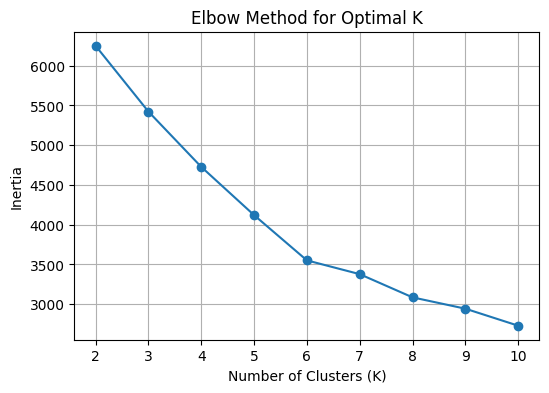

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()


In [ ]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

df[["Datetime", "Cluster"]].head()


,Datetime,Cluster
0,2021-01-01,2
1,2021-01-02,2
2,2021-01-03,2
3,2021-01-04,0
4,2021-01-05,0


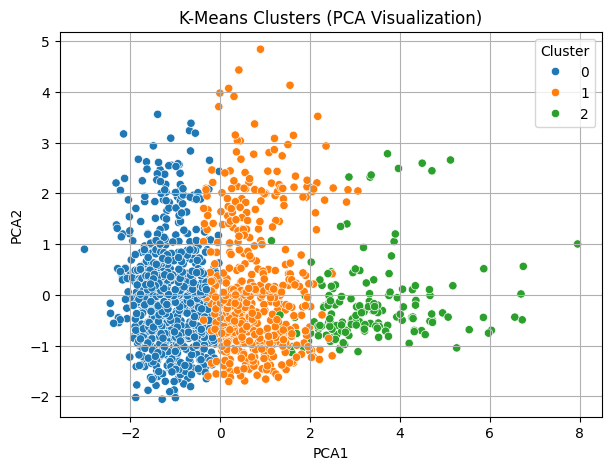

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["PCA1"] = X_pca[:,0]
df["PCA2"] = X_pca[:,1]

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df,
    x="PCA1",
    y="PCA2",
    hue="Cluster",
    palette="tab10"
)
plt.title("K-Means Clusters (PCA Visualization)")
plt.grid(True)
plt.show()


In [ ]:
cluster_summary = df.groupby("Cluster")[features].mean().round(2)
cluster_summary


,PM2.5,PM10,NO2,SO2,CO,Ozone
Cluster,,,,,,
0,48.40,128.91,27.50,19.29,0.68,41.69
1,117.38,303.79,36.07,23.35,1.19,30.80
2,220.01,399.51,88.94,14.14,2.25,26.74


In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1.5, min_samples=10)
db_labels = db.fit_predict(X_scaled)

df["DBSCAN_Label"] = db_labels
df["Anomaly"] = (db_labels == -1)

In [ ]:
print("Total Anomalies Detected:", df["Anomaly"].sum())


Total Anomalies Detected: 57


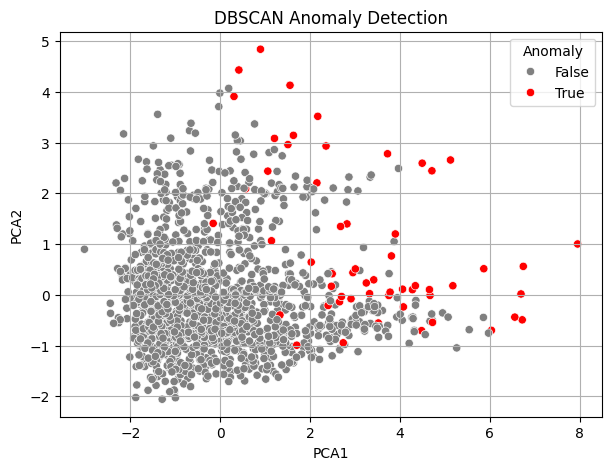

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df,
    x="PCA1",
    y="PCA2",
    hue="Anomaly",
    palette={True: "red", False: "gray"}
)
plt.title("DBSCAN Anomaly Detection")
plt.grid(True)
plt.show()


In [ ]:
anomalies = df[df["Anomaly"] == True][["Datetime"] + features]
anomalies.head(10)


,Datetime,PM2.5,PM10,NO2,SO2,CO,Ozone
0,2021-01-01,408.80,442.42,160.61,12.95,2.77,43.19
14,2021-01-15,462.62,517.76,178.15,10.11,2.51,25.81
17,2021-01-18,232.16,318.10,210.31,14.92,1.32,28.17
20,2021-01-21,182.39,243.84,276.46,5.60,1.50,33.70
115,2021-04-26,202.91,341.63,73.25,34.42,2.53,51.00
118,2021-04-29,215.39,406.98,58.30,25.24,2.21,60.72
304,2021-11-01,151.11,255.77,97.32,7.55,4.70,28.41
306,2021-11-03,172.52,277.81,95.15,7.33,3.39,31.81
314,2021-11-11,369.13,434.16,150.17,7.75,3.93,20.39
315,2021-11-12,387.18,451.81,101.76,7.96,4.02,23.80


In [ ]:
print("Clustering completed using K-Means (K=3) and anomalies detected using DBSCAN.")
print("This notebook extends the previous predictive models by revealing natural pollution groups and extreme outlier days.")


Clustering completed using K-Means (K=3) and anomalies detected using DBSCAN.
This notebook extends the previous predictive models by revealing natural pollution groups and extreme outlier days.
